# Basic Python Trading Strategy Project

## Introduction

This example project was created to practice my new Python skills from a course I completed called "Python and Statistics for Financial Analysis" which was delivered by The Hong Kong University of Science and Technology (via Coursera). In the project, I utilised Python to extract financial data from Yahoo Finance and develop a basic trading strategy. Using multiple linear regression, I ran a number of indices on the SPY ETF and used the results to predict movements in the SPY. The predictions then served as the signal for my trading strategy. Following this, I set the strategy for Python to long one share when the signal was positive, and to short one share if the signal was negative. The results were then plotted against a simple Buy-and-Hold strategy for comparison. The model's performance was evaluated by using the Sharpe Ratio and the Maximum Drawdown. This project is a simple starting point for my journey in learning to code with Python for economic and financial analysis.

## The Code

Importing necessary libraries

In [79]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf

Importing the data

In [80]:
aord = yf.Ticker("^AORD")      # All Ordinaries (Australia)
nikkei = yf.Ticker("^N225")    # Nikkei 225 (Japan)
hsi = yf.Ticker("^HSI")        # Hang Seng Index (Hong Kong)
daxi = yf.Ticker("^GDAXI")     # DAX Index (Germany)
cac40 = yf.Ticker("^FCHI")     # CAC 40 (France)
sp500 = yf.Ticker("^GSPC")     # S&P 500 (USA)
dji = yf.Ticker("^DJI")        # Dow Jones Industrial Average (USA)
nasdaq = yf.Ticker("^IXIC")    # NASDAQ Composite (USA)
spy = yf.Ticker("SPY")         # SPDR S&P 500 ETF (USA)

# Get historical data
aord_data = aord.history(period="max")
nikkei_data = nikkei.history(period="max")
hsi_data = hsi.history(period="max")
daxi_data = daxi.history(period="max")
cac40_data = cac40.history(period="max")
sp500_data = sp500.history(period="max")
dji_data = dji.history(period="max")
nasdaq_data = nasdaq.history(period="max")
spy_data = spy.history(period="max")


## Cleaning the Data

Standardising timezones

In [81]:

for df in [cac40_data, daxi_data, aord_data, hsi_data, nikkei_data,
           spy_data, sp500_data, nasdaq_data, dji_data]:
    df.index = pd.to_datetime(df.index).tz_localize(None).normalize()


Calculating price changes

In [82]:
modeldata=pd.DataFrame(index=spy_data.index)

modeldata['spy']=spy_data['Open'].shift(-1)-spy_data['Open']
modeldata['spy_lag1']=modeldata['spy'].shift(1)
modeldata['sp500']=sp500_data["Open"]-sp500_data['Open'].shift(1)
modeldata['nasdaq']=nasdaq_data['Open']-nasdaq_data['Open'].shift(1)
modeldata['dji']=dji_data['Open']-dji_data['Open'].shift(1)

modeldata['cac40']=cac40_data['Open']-cac40_data['Open'].shift(1)
modeldata['daxi']=daxi_data['Open']-daxi_data['Open'].shift(1)

modeldata['aord']=aord_data['Close']-aord_data['Open']
modeldata['hsi']=hsi_data['Close']-hsi_data['Open']
modeldata['nikkei']=nikkei_data['Close']-nikkei_data['Open']
modeldata['Price']=spy_data['Open']

Cleaning the data i.e., removing NaN values

In [83]:
modeldata.isnull().sum()

spy           1
spy_lag1      1
sp500         1
nasdaq        0
dji           0
cac40       125
daxi        153
aord        171
hsi         368
nikkei      470
Price         0
dtype: int64

Fill forward then drop remaining missing values (if any)

In [84]:
modeldata = modeldata.ffill()
modeldata = modeldata.dropna()

In [85]:
modeldata.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [25]:
modeldata.head(1000)

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
1993-02-01,0.139122,-0.000005,0.109985,1.019958,3.699951,-17.699951,16.289917,0.900024,-45.500000,96.121094,24.469912
1993-02-02,0.104363,0.139122,3.739990,4.270020,22.199951,32.299927,-6.189941,-0.300049,-30.799805,39.630859,24.609034
1993-02-03,0.313046,0.104363,0.040009,5.429993,-3.300049,-1.299927,21.770020,0.000000,48.299805,-4.521484,24.713397
1993-02-04,0.000002,0.313046,4.640015,2.350037,45.200195,37.399902,10.069946,-0.199951,54.500000,-82.769531,25.026443
1993-02-05,0.000000,0.000002,2.359985,-3.200012,42.599854,42.500000,27.849976,11.900024,-40.099609,109.259766,25.026445
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,1.029968,0.669983,6.729980,83.259766,-86.238281,16.120117,27.521484,-1.600586,78.281250,-35.902344,597.630005
2025-06-06,1.059998,1.029968,1.390137,8.791016,143.929688,-16.300293,23.158203,-26.699219,-149.031250,151.167969,598.659973
2025-06-09,0.500000,1.059998,17.569824,46.150391,154.371094,1.379883,-52.109375,-26.699219,203.890625,59.859375,599.719971


Splitting the data into a training and testing sets for the OLS model

In [86]:
Train = modeldata.iloc[-2000:-1000, :]
Test = modeldata.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 11) (1000, 11)


Exploring the data set

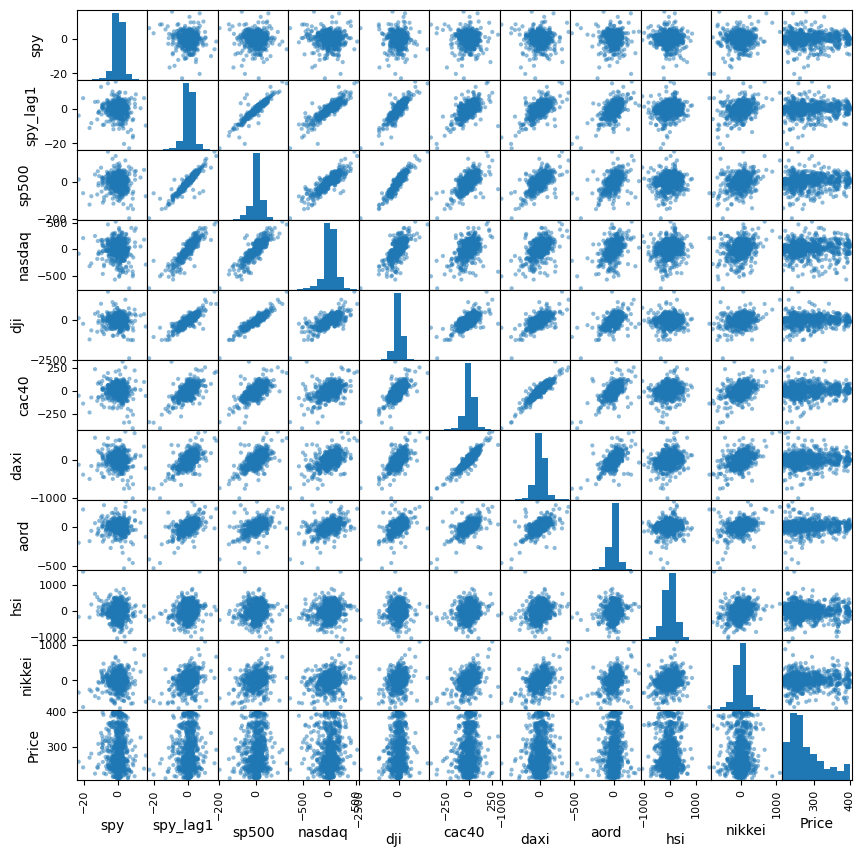

In [87]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))
plt.show()

Checking correlations:

In [88]:
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.081904
sp500      -0.029156
nasdaq     -0.051042
dji        -0.042733
cac40      -0.040118
daxi       -0.051757
aord       -0.035056
hsi        -0.087379
nikkei      0.075634
Name: spy, dtype: float64


## Empirical results

Running the OLS model

In [89]:
equation = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=equation, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     5.475
Date:                Thu, 12 Jun 2025   Prob (F-statistic):           2.28e-07
Time:                        14:38:23   Log-Likelihood:                -2558.1
No. Observations:                1000   AIC:                             5136.
Df Residuals:                     990   BIC:                             5185.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1811      0.100      1.815      0.070      -0.015       0.377
spy_lag1      -0.4288      0.109     -3.929      0.000      -0.643      -0.215
sp500          0.0477      0.015      3.096      0.002       0.017       0.078
nasdaq      -5.15e-05      0.002     -0.021      0.983      -0.005       0.005
dji           -0.0012      0.001     -0.954      0.340      -0.004       0.001
cac40          0.0012      0.004      0.279      0.780      -0.007       0.010
aord           0.0021      0.002      0.981      0.327      -0.002       0.006
daxi          -0.0022      0.002     -1.320      0.187      -0.005       0.001
nikkei         0.0027      0.001      4.360      0.000       0.001       0.004
hsi           -0.0010      0.000     -2.243      0.025      -0.002      -0.000
==============================================================================
Omnibus:                      258.871   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2354.144
Skew:                          -0.914   Prob(JB):                         0.00
Kurtosis:                      10.291   Cond. No.                         366.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Making predictions based on the results

In [92]:
Train.loc[:, 'PredictedY'] = lm.predict(Train)
Test.loc[:, 'PredictedY'] = lm.predict(Test)  

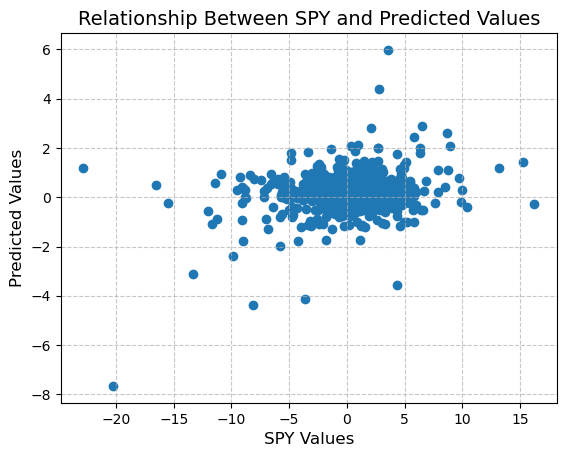

In [91]:
plt.scatter(Train['spy'], Train['PredictedY'])
plt.title('Relationship Between SPY and Predicted Values', fontsize=14)
plt.xlabel('SPY Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Setting up the Trading Strategy and Results

Setting up a siganl trading strategy using the train set:

In [94]:
Train.loc[:, 'Order'] = [1 if sig > 0 else -1 for sig in Train['PredictedY']]
Train.loc[:, 'Profit'] = Train['spy'] * Train['Order']
Train.loc[:, 'Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())


Total profit made in Train:  171.01134025965666


Plotting signal based trading strategy against buy and hold

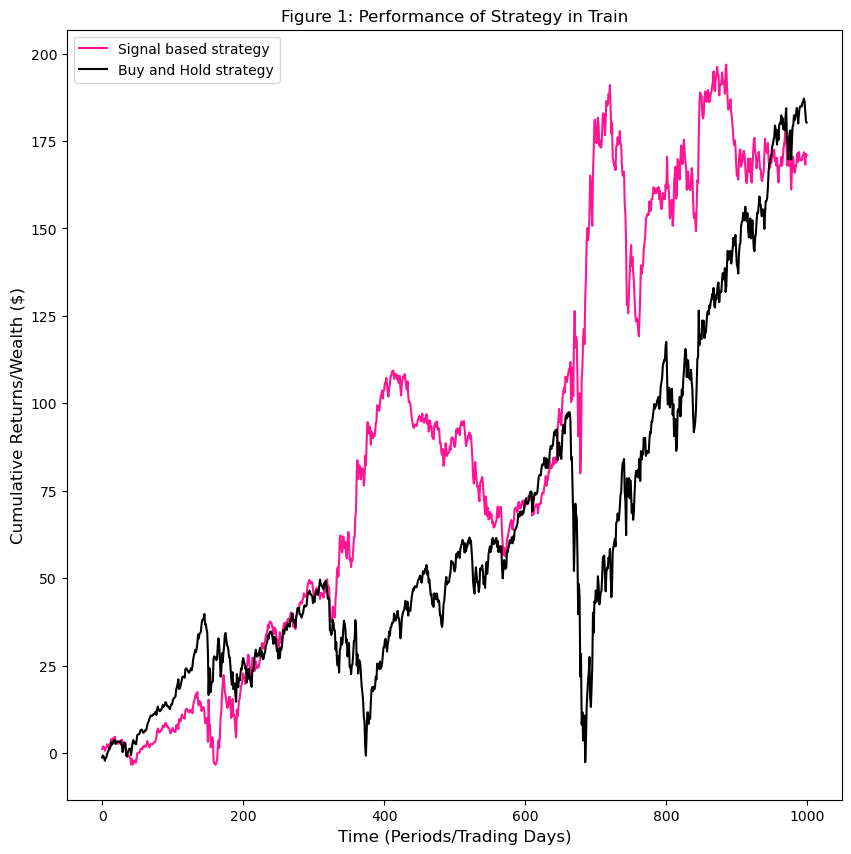

In [95]:
plt.figure(figsize=(10, 10))
plt.title('Figure 1: Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='deeppink', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='black', label='Buy and Hold strategy')
plt.legend()
plt.xlabel('Time (Periods/Trading Days)', fontsize=12)  
plt.ylabel('Cumulative Returns/Wealth ($)', fontsize=12)  
plt.show()

To ensure consistency, the exercise is repeated using the Test data

In [97]:
Test.loc[:, 'Order'] = [1 if sig > 0 else -1 for sig in Train['PredictedY']]
Test.loc[:, 'Profit'] = Test['spy'] * Test['Order']
Test.loc[:, 'Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  152.07569448472395


Plotting signal based trading strategy against buy and hold

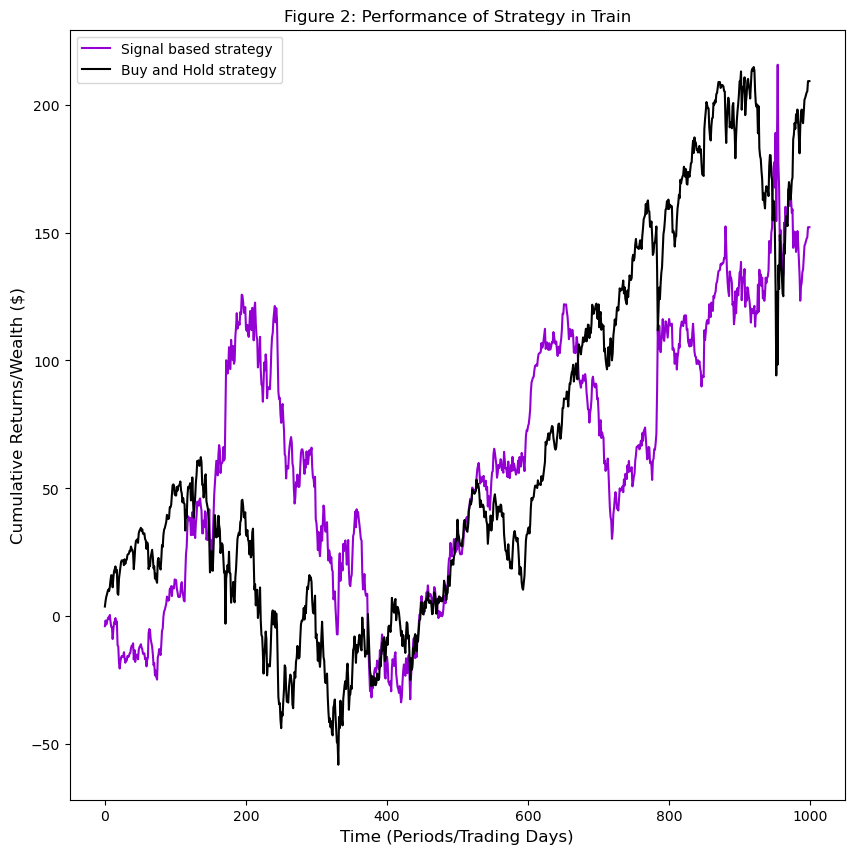

In [98]:
plt.figure(figsize=(10, 10))
plt.title('Figure 2: Performance of Strategy in Train')
plt.plot(Test['Wealth'].values, color='darkviolet', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='black', label='Buy and Hold strategy')
plt.legend()
plt.xlabel('Time (Periods/Trading Days)', fontsize=12)  
plt.ylabel('Cumulative Returns/Wealth ($)', fontsize=12) 
plt.show()

## Evaluating the model performance using the Sharpe Ratio and Maximum draw down

Adding the initial cost of the index to wealth in order to calculate our model performance metrics

In [69]:
Train.loc[:,'Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test.loc[:,'Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

Sharp Ratio on Train Data

In [74]:
# Sharp ratio on train data:
Train.loc[:,'Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.05660090340512225
Yearly Sharpe Ratio is  0.8985114863492548


Sharpe Ratio in Test Data

In [75]:
# Sharpe Ratio in Test data
Test.loc[:,'Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.028788829882755825
Yearly Sharpe Ratio is  0.45700850643790014


Maximum Drawdown in Train data

In [76]:
# Maximum Drawdown in Train data
Train.loc[:,'Peak'] = Train['Wealth'].cummax()
Train.loc[:,'Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

Maximum Drawdown in Train is  0.11592538471813818


Maximum Drawdown in Test data

In [77]:
# Maximum Drawdown in Test data
Test.loc[:,'Peak'] = Test['Wealth'].cummax()
Test.loc[:,'Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Maximum Drawdown in Test is  0.1739016656275169


## Interpretation of Results

The performance comparison between the signal-based strategy and the Buy-and-Hold strategy reveals mixed results. In the training data (Figure 1), the signal-based strategy initially underperforms but eventually surpasses the Buy-and-Hold strategy, achieving higher cumulative returns by the end of the period. However, in the test data (Figure 2), the signal-based strategy underperforms, ending with lower cumulative returns.

The Sharpe Ratio, which measures risk-adjusted returns, is higher in the training data (0.90 yearly) compared to the test data (0.46 yearly), indicating better performance during the training phase. The Maximum Drawdown, reflecting the largest peak-to-trough decline, is also lower in the training data (11.6%) than in the test data (17.4%), suggesting greater resilience during training.

These results highlight the possibility of overfitting, as the model performed well in training but struggled to navigate the unseen data. While the signal-based strategy shows potential, further refinement is needed to improve its robustness. This was done as a simple first project and I hope to hone my skills further to eventually do full scale projects.